<div align="center">

# Vehicule's License Plate Detection

 </div>

Vehicle License plate detection and recognition is a well-known challenge that has been tackled by many computer-vision labs and companies. However, each country has its own specific license plate formats. This challenge is targeting regular Tunisian license plates. The data provided for this challenge is composed of two datasets:
A set of vehicle images (900 images) taken from the internet and annotated manually. The annotations are the coordinates of the bounding box containing the license plate.
A set of license plate images (900 images) where the annotations are the text written in the license plate.

The project will be hold in 3 phases:
1. Exploratory Data Analysis (EDA) phase, where you are supposed to work on understanding, clearing, sorting and extracting important features from the data provided. **Estimated Task Time:** 1 day

2. Modeling phase, where you will be able to use all the work done in EDA in order to create your own DL model (or models). **Estimated Task Time:** 3 days



In [1]:
import cv2
import  tensorflow as tf
import pandas as pd
import numpy as np



from project.image_preprocess.data_aug.data_aug import *
from project.image_preprocess.data_aug.bbox_util import *

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.pyplot import figure

import random

from PIL import Image

2022-02-14 19:44:45.660848: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hafsa/anaconda3/envs/nilmtk-env/lib/python3.8/site-packages/cv2/../../lib64:
2022-02-14 19:44:45.660897: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Exploratory Data Analysis

First, let's load the training the data and explore the shape of the images.

In [2]:
def load_data(path='./data/train/', path_targets='./data/train_target.csv'):
    """
    loads the labels and their images
    
    :path path to the data directory
    """
    # L
    df_target = pd.read_csv(f'{path_targets}')
    # load the images in the same order of the target DF
    images = []
    images_metadata = {
        'width':[],
        'height':[]
    }
    for image in df_target['img_id']:
        images.append(np.array(Image.open(f'{path}/{image}')))
        # Getting information about the images shape 
        images_metadata['height'].append(images[-1].shape[1])
        images_metadata['width'].append(images[-1].shape[0])
    df_target['heights'] = images_metadata['height']
    df_target['width'] = images_metadata['width']
    return images, df_target

images, targets = load_data()

### Check that all images have 3 channels

In [3]:
assert np.array([image.shape[2] == 3 for image in images]).all()

### Check the shape of the images

Text(0, 0.5, 'Count')

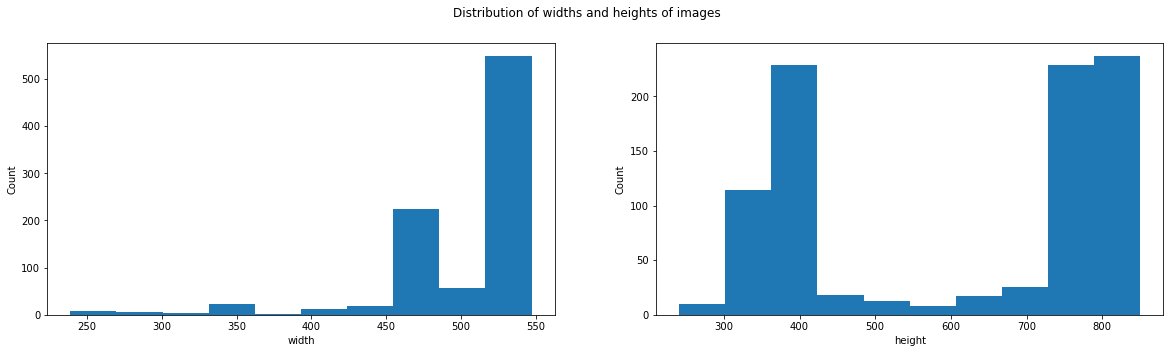

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(20,5))
fig.suptitle('Distribution of widths and heights of images')
axs[0].hist(targets['width'])
axs[0].set_xlabel('width')
axs[0].set_ylabel('Count')
axs[1].hist(targets['heights'])
axs[1].set_xlabel('height')
axs[1].set_ylabel('Count')

The plots above show that the images are not of the same size and we should fix problem as the NN will only accept a fixed shape as input

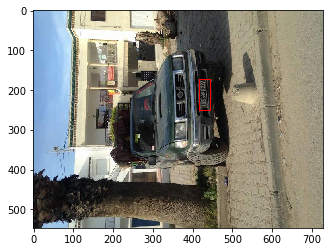

In [6]:
def plot_image(image, x_min, y_min, x_max, y_max):
    """
    Plots the image of the car with a bounding box around the licence plate
    
    :image: the image of the car
    :x_min : the minimum x position of the box
    :y_min : the minimum y position of the box
    :x_max : the maximum x position of the box
    :y_max : the maximum y position of the box
    """
    # Create figure and axes
    fig, ax = plt.subplots()
    # Display the image
    ax.imshow(image)
    # Create a Rectangle patch
    rect = patches.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, linewidth=1, edgecolor='r', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    plt.show()
    

def plot_random_image(images, targets, index=None):
    """
    Plots a random image (or the image at the position index)
    """
    if index is None:
        index = random.randint(0, len(images))
    y_min, x_min, y_max, x_max = targets.iloc[index][['ymin', 'xmin', 'ymax', 'xmax' ]]
    plot_image(images[index], x_min, y_min, x_max, y_max)
    
    
plot_random_image(images, targets)

### Distribution of plates position in the images

[]

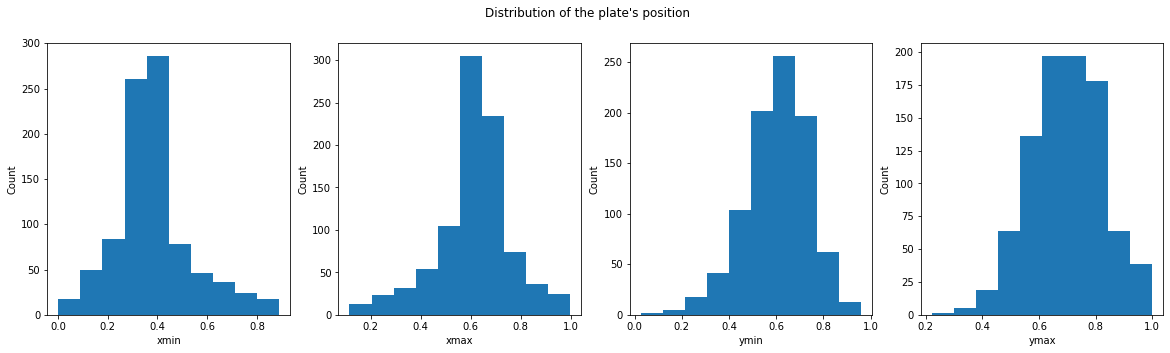

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(20,5))
fig.suptitle("Distribution of the plate's position")

tmp_targets = targets.copy()


tmp_targets[['xmin', 'xmax']] = tmp_targets[['xmin', 'xmax']].values / tmp_targets['heights'].values.reshape(-1,1)
tmp_targets[['ymin', 'ymax']] = tmp_targets[['ymin', 'ymax']].values / tmp_targets['width'].values.reshape(-1,1)

columns = ['xmin', 'xmax', 'ymin',  'ymax']

for i in range(len(columns)):
    axs[i].hist(tmp_targets[columns[i]])
    axs[i].set_xlabel(columns[i])
    axs[i].set_ylabel('Count')
plt.plot()

The above distribution shows that the plates in the proposed dataset are mostely centered around one position. This would mean that we have some bias?!

## Suggested Solution

**Objective** The objective of this challenge is 
1. to detect the vehicle’s license plates then 
2. recognize the characters in each license plate. 

The proposed solution is as follows

<img src='system.png' />

## Data Pre-processing

In [3]:
# Change all images to the same shape
def reshape(image, plate_position, new_size=224):
    img_ = cv2.resize(image, (new_size,new_size), interpolation = cv2.INTER_AREA)
    x_min, y_min, x_max, y_max = plate_position.reshape(-1)
    scale1 = new_size / image.shape[1] 
    scale2 = new_size / image.shape[0] 
    x_min = x_min * scale1
    x_max = x_max * scale1
    y_min = y_min * scale2
    y_max = y_max * scale2
    return img_, np.array([x_min, y_min, x_max, y_max])
    
def reshape_images(images,target_df, new_shape=224):
    new_images =[]
    new_position = []
    
    for i in range(len(images)):
        plate_position = target_df.loc[i, ['xmin','ymin', 'xmax', 'ymax' ]].values.reshape(1,-1)
        resized_image, new_box = reshape(images[i], plate_position, new_shape)
        new_images.append(resized_image)
        new_position.append([new_box ])

    new_targets = pd.DataFrame(np.array(new_position).reshape(-1,4))
    new_targets.columns = ['xmin', 'ymin', 'xmax', 'ymax' ]
    new_targets[[ 'xmin', 'ymin',  'xmax', 'ymax']] = new_targets[[ 'xmin', 'ymin',  'xmax', 'ymax']].astype(int)
    new_targets ['img_id'] = target_df['img_id']
    return new_images, new_targets
    

In [8]:
new_images, new_targets = reshape_images(images, targets)

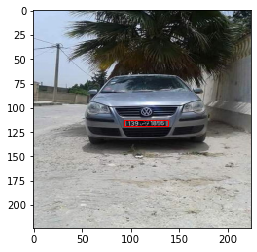

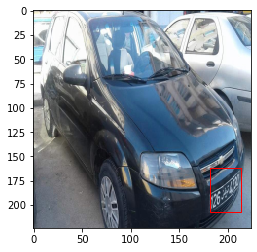

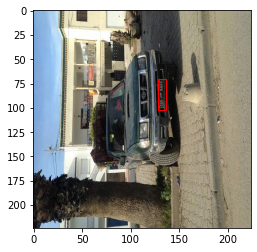

In [9]:
for i in range(3):
    plot_random_image(new_images, new_targets)

## Data augmentation

The task here is to augment the training images using random images from the library. As suggested in previous discussion, each image would generate 10 different images but the transformations should be random for each image. 

Please also check the distribution of xmin, xmax, ymin and ymin at the end.

**Expected output: A shared drive with 9000**

**Responsible: Chihab**

**Deadline: Wednesday**

In [11]:
def augment_image(img, bbox, img_id='img', augmented_path='./data/aug_data', nb_new_images=5):
    boxes = {}
    # Change the current directory 
    # to specified directory 
    str_ = %pwd
    os.chdir(augmented_path)
    cv2.imwrite(f'{img_id}', img)
    boxes[f'{img_id}']= bbox
    
    for i in range(nb_new_images):
        # Select a random set of transforms
        transforms = np.array([
                    RandomHorizontalFlip(),
                    RandomScale(np.random.random(), diff = True),
#                     Rotate(np.random.randint(0,180,1)[0]),
                    RandomTranslate(np.random.random(), diff = True),
                    RandomShear(np.random.random()),
                    RandomHSV(100, 100, 100)
                ])
        random_idx = np.unique(np.random.randint(0,len(transforms), np.random.randint(1,len(transforms),1)))
        seq = Sequence(transforms[random_idx])
        img_, bboxes_ = seq(img.copy(), bbox.copy())
        if bboxes_.shape[0]!=0:
            cv2.imwrite(f'{i}_{img_id}', img_)
            boxes[f'{i}_{img_id}'] = bboxes_
    os.chdir(str_)
    return boxes

def augment_images(images, targets):
    
    aug_labels = {}
    
    for i in range(len(images)):
        img= images[i]
        bboxes = new_targets.iloc[i][[ 'xmin', 'ymin',  'xmax', 'ymax']].values.reshape(1,-1)
        img_id = new_targets.iloc[i]['img_id']
        aug_label = augment_image(img, bboxes, img_id)
        aug_labels.update(aug_label)
        
    return aug_labels

new_labels = augment_images(new_images, new_targets)

In [12]:
new_boxes = pd.DataFrame([{
    'img_id':key,
    'xmin': new_labels[key][0][0],
    'ymin': new_labels[key][0][1],
    'xmax': new_labels[key][0][2],
    'ymax': new_labels[key][0][3]} for key in new_labels]).sample(frac=1).reset_index(drop=True)
new_boxes.head()
new_boxes.to_csv('./data/aug_images.csv')

In [4]:
train_images, train_labels = load_data(path='./data/aug_data',
                                       path_targets='./data/aug_images.csv')

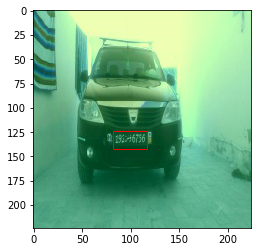

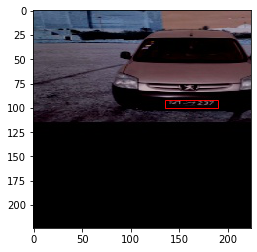

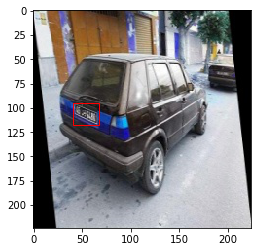

In [10]:
for i in range(3):
    plot_random_image(train_images, train_labels)

## Plate position Detection

The task here is downlaod a pre-trained model for the licence plate detection. A model that only detects the position of the plate. 
1. First, test the model directly on the test set and measure the performance. if the performance is very good, we may use it directly. 

2. Then the model should be retrained on the augmented data from previous step. The performance should be measured once again on the test data.

**Expected output:** A shared drive containing the checkpoint for the model, 2 csv files for the training and validation losses and a csv file for the test predictions.

**Responsible:** Abla

**Deadline for 1:** Wednesday

**Deadline for 2:** Thursday

In [11]:
input_data = np.array(train_images)/255
target_data = train_labels[[ 'xmin', 'ymin',  'xmax', 'ymax']].values
mean = target_data.mean(axis=0).reshape(-1,4)
std = target_data.std(axis=0).reshape(-1,4)

# target_data = (target_data - mean)/std
target_data = target_data/224

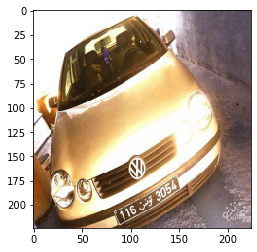

In [12]:
plt.imshow(input_data[0])

In [14]:
# import the necessary packages
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.layers import Flatten, Conv2D, Dense, Input, BatchNormalization, MaxPool2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
# define the base path to the input dataset and then use it to derive
# the path to the images directory and annotation CSV file
BASE_PATH = "data"
IMAGES_PATH = os.path.sep.join([BASE_PATH, "train_data"])
LEBELS_PATH = os.path.sep.join([BASE_PATH, "train_target.csv"])

# define the path to the base output directory
BASE_OUTPUT = "output"
# define the path to the output serialized model, model training plot,
# and testing image filenames
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector.h5"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_FILENAMES = os.path.sep.join([BASE_OUTPUT, "test_data"])

# initialize our initial learning rate, number of epochs to train
# for, and the batch size
INIT_LR = 1e-5
NUM_EPOCHS = 500
BATCH_SIZE = 32

In [15]:
from numpy.core.numeric import True_
# load the VGG16 network, ensuring the head FC layers are left off
#vgg = VGG16(include_top=False, weights='imagenet', input_tensor=Input(shape=(224, 224, 3)))

#resnet50 = ResNet50(include_top=False, weights='imagenet', input_tensor=Input(shape=(224, 224, 3)))

inceptionV3 = InceptionV3( include_top=False, weights='imagenet', input_tensor=Input(shape=(224, 224, 3)))

# freeze all VGG layers so they will *not* be updated during the
# training process
#vgg.trainable = False
#resnet50.trainable = False
inceptionV3.trainable = False

# flatten the max-pooling output of VGG
#flatten = vgg.output
#flatten = resnet50.output
flatten = inceptionV3.output

flatten = Flatten()(flatten)
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(512, activation="relu")(flatten)
bboxHead = Dense(128, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)
# construct the model we will fine-tune for bounding box regression
#model = Model(inputs=vgg.input, outputs=bboxHead)
#model = Model(inputs=resnet50.input, outputs=bboxHead)
model = Model(inputs=inceptionV3.input, outputs=bboxHead)


2022-02-14 19:46:30.335572: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-14 19:46:30.336252: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hafsa/anaconda3/envs/nilmtk-env/lib/python3.8/site-packages/cv2/../../lib64:
2022-02-14 19:46:30.336320: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hafsa/anaconda3/envs/nilmtk-env/lib/python3.8/site-packages/cv2/../../lib64:
2022-02-14 19:46:30.336357: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library

In [17]:
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(learning_rate=1e-4)
model.compile(loss="mse", optimizer=opt)

# train the network for bounding box regression
print("[INFO] training bounding box regressor...")
with tf.device('/device:GPU:0'):
    H = model.fit(
        input_data, target_data,
        validation_split=.1,
        batch_size=32,
        epochs=40,
        verbose=1)

# serialize the model to disk
import logging 

logging.info("saving object detector model...")
model.save('./data/detector_less_Dense', save_format="h5")

[INFO] training bounding box regressor...
Epoch 1/40
134/134 [==============================] - 96s 693ms/step - loss: 0.0502 - val_loss: 0.0416
Epoch 2/40
134/134 [==============================] - 91s 681ms/step - loss: 0.0109 - val_loss: 0.0088
Epoch 3/40
134/134 [==============================] - 90s 675ms/step - loss: 0.0045 - val_loss: 0.0072
Epoch 4/40
134/134 [==============================] - 94s 699ms/step - loss: 0.0029 - val_loss: 0.0070
Epoch 5/40
134/134 [==============================] - 100s 744ms/step - loss: 0.0021 - val_loss: 0.0066
Epoch 6/40
134/134 [==============================] - 98s 730ms/step - loss: 0.0017 - val_loss: 0.0062
Epoch 7/40
134/134 [==============================] - 98s 729ms/step - loss: 0.0015 - val_loss: 0.0059
Epoch 8/40
134/134 [==============================] - 91s 682ms/step - loss: 0.0013 - val_loss: 0.0059
Epoch 9/40
134/134 [==============================] - 92s 684ms/step - loss: 0.0012 - val_loss: 0.0059
Epoch 10/40
134/134 [=========

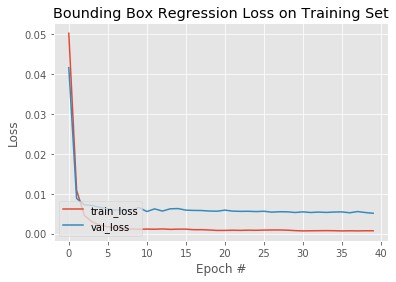

In [18]:
# plot the model training history
N = 40
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

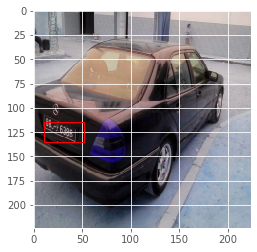

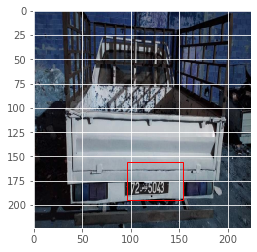

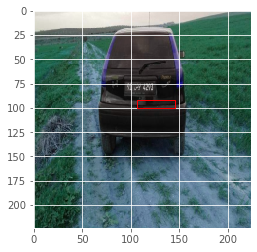

In [24]:
for i in range(3):
    img_test = cv2.imread(f'./data/test/{np.random.randint(901,1114)}.jpg')
    img = cv2.resize(img_test, (224,224), interpolation = cv2.INTER_AREA) / 255
    img = np.expand_dims(img, axis=0)
    predicted_bboxes = model(img)*224
    x_min, y_min, x_max, y_max = predicted_bboxes.numpy().astype(int).reshape(-1)
    plot_image(img.reshape((224,224,3)), x_min, y_min, x_max, y_max )

## Image Segmentation

The task is to seperate the digits in the plates and detect the content of each one of them.
The plates in Tunisia take the form XXX تونس XXXX where X is a number between 0 and 9. 

**Responsible:** Hafsa

**Deadline:** Wednesday

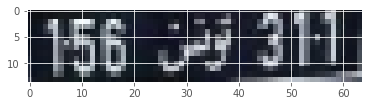

In [25]:
def extract_plate(image, box):
    """
    Extracts the subimage of box from the original image
    """
    xmin, ymin, xmax, ymax = box
    return image[ymin+2:ymax-2, xmin+2:xmax-2, :]

def split(char):
    nb_char = 1 + char.shape[1]//15
    width = char.shape[1] // nb_char
    if nb_char >1:
        lst_chars = []
        for c in range(nb_char):
            lst_chars.append(cv2.resize(char[:,c*width:(c+1)*width], (28,28), interpolation = cv2.INTER_AREA))
        return lst_chars
    return [cv2.resize(char, (28,28), interpolation = cv2.INTER_AREA)]

def segment_plate(plate, plates_dim= (70,20)):
    """
    segments the digits in the plate
    """
    plate = plate.astype(np.uint8)
    plate = cv2.cvtColor(plate, cv2.COLOR_RGB2GRAY)
    plate = cv2.resize(plate, (70,20), interpolation = cv2.INTER_AREA)
    ret, thresh = cv2.threshold(plate, 100, 255, cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    chars = []
    x_cntr_list =[]
    for i,contour in enumerate(contours) :
        intX, intY, intWidth, intHeight = cv2.boundingRect(contour)
        #checking the dimensions of the contour to filter out the characters by contour's size
        x_cntr_list.append((intX, intY, intWidth, intHeight ))
        if intHeight>=10 and intWidth>=3:
            char = plate[intY:intY+intHeight, intX:intX+intWidth]
            chars = chars + split(char)
            
    return chars, x_cntr_list


def plot_plate(plate):
    plt.imshow(plate)
    plt.show()

# new_images,
index = 150
xmin, ymin, xmax, ymax = new_targets.iloc[index][[ 'xmin', 'ymin',  'xmax', 'ymax']]
image = new_images[index]
plate = extract_plate(image,(xmin, ymin, xmax, ymax))
plot_plate(plate)

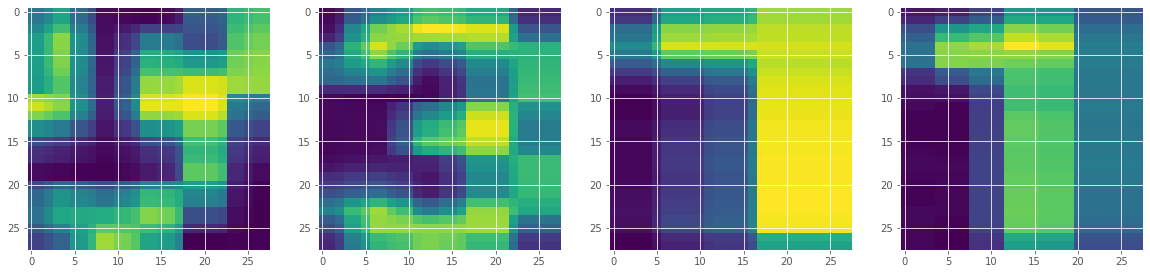

In [26]:
right_part = plate[:,-plate.shape[1]//2:,:]
chars, list_ = segment_plate(right_part)

fig, axs = plt.subplots(1, len(chars), figsize=(20,5))
for i in range(len(chars)):
    axs[i].imshow(chars[i])

## Characters Detection

The task here is to detect the value of each digit in the plate adn generate the number of the plate

**Responsible:** Hafsa

**Deadline:** Wednesday

In [32]:
import numpy as np
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.astype(np.float32) /255
X_test = X_test.astype(np.float32) /255

X_train =  np.expand_dims(X_train, axis=-1)
X_test =  np.expand_dims(X_test, axis=-1)

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from tensorflow.keras import optimizers


def get_char_cnn():
    model = Sequential()
    model.add(Conv2D(32, (3,3), input_shape=(28, 28, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    
    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
    model.summary()
    #loading pretrained weights saved using training char cnn
    return model

model = get_char_cnn()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_98 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_99 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 1600)              0         
                                                                 
 dropout_2 (Dropout)         (None, 1600)             

In [41]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_accuracy', min_delta=.01, patience=4, verbose=1)
mc = ModelCheckpoint('./data/digit_recogniser.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
cb = [es, mc]

model.fit(X_train, y_train, validation_split=0.15 , batch_size=32, epochs=50, callbacks=cb)

Epoch 1/50
1593/1594 [============================>.] - ETA: 0s - loss: 0.6707 - accuracy: 0.8128
Epoch 00001: val_accuracy improved from -inf to 0.94667, saving model to ./data/digit_recogniser.h5
1594/1594 [==============================] - 14s 9ms/step - loss: 0.6707 - accuracy: 0.8127 - val_loss: 0.1981 - val_accuracy: 0.9467
Epoch 2/50
1592/1594 [============================>.] - ETA: 0s - loss: 0.2121 - accuracy: 0.9367
Epoch 00002: val_accuracy improved from 0.94667 to 0.96267, saving model to ./data/digit_recogniser.h5
1594/1594 [==============================] - 14s 8ms/step - loss: 0.2120 - accuracy: 0.9367 - val_loss: 0.1352 - val_accuracy: 0.9627
Epoch 3/50
1591/1594 [============================>.] - ETA: 0s - loss: 0.1525 - accuracy: 0.9544
Epoch 00003: val_accuracy improved from 0.96267 to 0.97056, saving model to ./data/digit_recogniser.h5
1594/1594 [==============================] - 14s 8ms/step - loss: 0.1527 - accuracy: 0.9543 - val_loss: 0.1046 - val_accuracy: 0.970

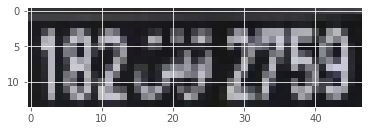

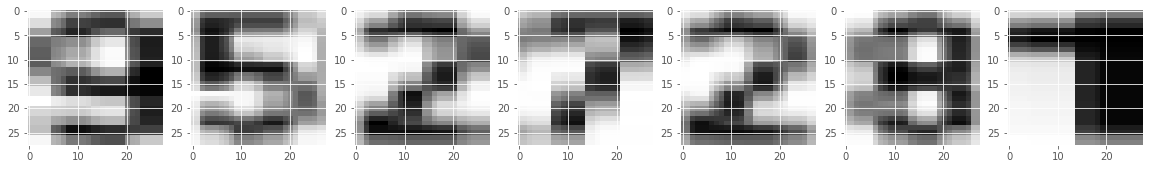

[5, 5, 2, 2, 2, 8, 7]

In [52]:
def recognise_digits(digits_images):
    lst = []
    model = tf.keras.models.load_model('./data/digit_recogniser.h5')
    for image in digits_images:
        image=np.expand_dims(image, axis=(0,-1))
        image [image>80]=255
        image[image!=255] = 0
        class_ = np.argmax(model(image)) 
        lst.append(class_)
    return lst

def get_plate_content(image, box, plot=True):
    """
    retruns the plate content limited 
    in the box of the image
    """
    plate_image =  extract_plate(image, box)
    if plot:
        plot_plate(plate_image)
    left_part = plate_image[:,:plate_image.shape[1]//2,:]
    right_part = plate_image[:,plate_image.shape[1]//2:,:]
    
    digits_image_right, _ = segment_plate(right_part)
    digits_image_left, _  = segment_plate(left_part)
    
    digits_image = digits_image_right[-4:] + digits_image_left[-3:]
    if plot:
        fig, axs = plt.subplots(1, len(digits_image), figsize=(20,5))
        for i in range(len(digits_image)):
            axs[i].imshow(digits_image[i], cmap='binary')
        plt.show()
    plate_content = recognise_digits(digits_image)
    return plate_content

# new_images,
index = 12
xmin, ymin, xmax, ymax = new_targets.iloc[index][[ 'xmin', 'ymin',  'xmax', 'ymax']]
image = new_images[index]
get_plate_content(image,(xmin, ymin, xmax, ymax))

In [84]:
def detect_recognise(image):
    detect_model = tf.keras.models.load_model('./data/detector_less_Dense')
    image = image / 255
    box = detect_model(np.expand_dims(image,axis=0))*224
    box = box.numpy().astype(int).reshape(-1)
    print(tuple(box))
    content = get_plate_content(image, tuple(box), plot=True)
    print(f"The plate content is as follows:{content}")
    return content


(90, 139, 144, 166)


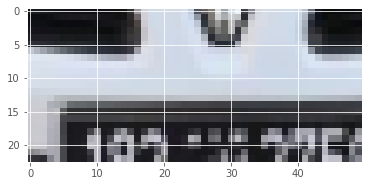

<Figure size 1440x360 with 0 Axes>

The plate content is as follows:[]


[]

In [86]:
index = np.random.randint(0,len(new_images), 1)[0]
image = new_images[12]
detect_recognise(image)